In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import sys
sys.path.append("../../../../../src")

import nanonets_utils

from scipy import signal

plt.style.use(["science","bright"])

In [321]:
N_samples   = 504
N_threads   = 36
N_voltages  = 1000
n_eq        = 300

def load_data(folder):
    
    arr1        = np.zeros(shape=(N_voltages-n_eq,N_samples))
    arr2        = np.zeros(shape=(N_voltages-n_eq,N_samples))
    time_step   = 1e-7
    t_vals      = np.arange(N_voltages-n_eq)*time_step*1e6

    rel_path    = f"../../../../../../data/2_funding_period/potential/magic_cable/{folder}/"
    x_vals      = pd.read_csv(f"{rel_path}Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv").loc[(n_eq-1):,'E0'].values*1000
    n           = 0

    for i in range(N_threads):
        for j in range(N_samples//N_threads):
            arr1[:,n]   =   pd.read_csv(f"{rel_path}Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv").loc[(n_eq-1):,'Current'].values*1000
            arr2[:,n]   =   pd.read_csv(f"{rel_path}Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv").loc[(n_eq-1):,'Error'].values*1000
            n           +=  1
    
    return t_vals, x_vals, arr1, arr2

def scale(arr):
    arr = (arr-np.mean(arr))/np.std(arr)
    arr = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    return arr

def return_best_fit(y_real_arr, y_target):

    y_target    = scale(y_target)
    rmse        = []

    for i in range(y_real_arr.shape[1]):
        
        y_real  = y_real_arr[:,i].copy()
        y_real  = scale(y_real)
        rmse.append(np.sqrt(np.sum((y_real-y_target)**2)))

    return np.argsort(rmse), rmse

## Sample

In [332]:
folder                      = 'amplitude'
t_vals, x_vals, arr1, arr2  = load_data(folder)

Text(0, 0.5, '$U_7$ [$mV$]')

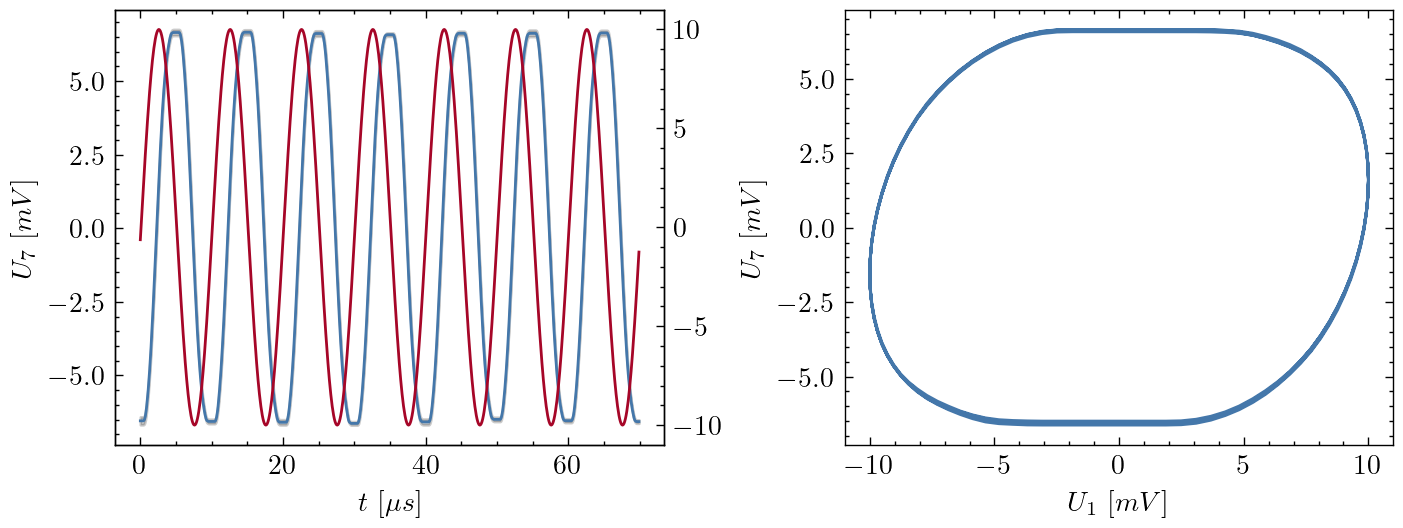

In [333]:
idx = 420

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t_vals, arr1[:,idx])
ax.fill_between(t_vals, arr1[:,idx]-arr2[:,idx], arr1[:,idx]+arr2[:,idx], color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu s$]')
ax.set_ylabel('$U_7$ [$mV$]')
ax2 = ax.twinx()
ax2.plot(t_vals, x_vals, c=nanonets_utils.red_color)

ax  = fig.add_subplot(1,2,2)
ax.plot(x_vals, arr1[:,idx])
ax.set_xlabel('$U_1$ [$mV$]')
ax.set_ylabel('$U_7$ [$mV$]')

## Train

In [334]:
y_target        = 10*signal.square(2*np.pi*t_vals*0.1)
# y_target        = 10*signal.sawtooth(2*np.pi*t_vals*0.1)
# y_target        = 10*signal.sawtooth(2*np.pi*t_vals*0.1, 0.5)
fit_order, rmse = return_best_fit(y_real_arr=arr1, y_target=y_target)
best_idx        = fit_order[1]

Text(0.5, 0, '$t$ [$\\mu s$]')

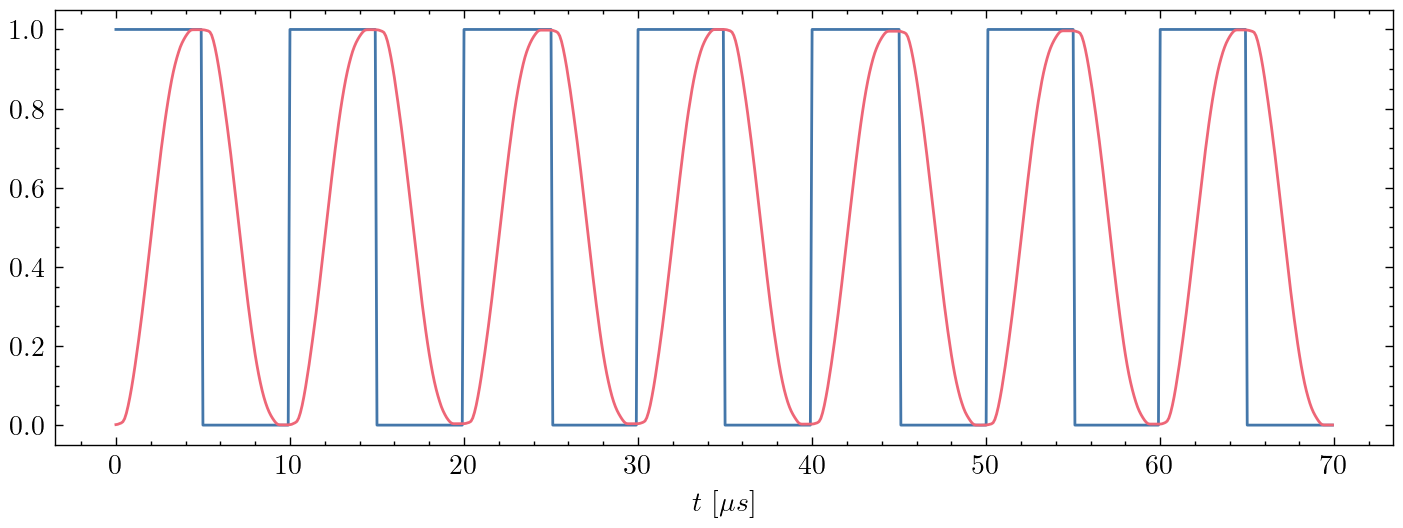

In [335]:
y_1 = scale(y_target)
y_2 = scale(arr1[:,best_idx])

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot()
ax.plot(t_vals, y_1)
ax.plot(t_vals, y_2)
ax.set_xlabel('$t$ [$\mu s$]')

## Shannon Rank

In [336]:
def shannon_rank(state : np.array):

    U, S, Vt    = np.linalg.svd(state)
    p           = S / np.sum(S)
    rank        = np.exp(-np.sum(p*np.log(p)))

    return rank